Import Libraries

In [3]:
import sqlite3
import requests
from tqdm import tqdm

from flask import Flask, request
import json 
import numpy as np
import pandas as pd

# Introduction
In most cases when we are running a business, there are a lot of data stakeholder outside our company. The problem is that we need to provide the access in a way that they will not break our security rules or concerns. One way to solve that is by creating an API for the database. In this project, we will introduce you on how python is used for data transaction management using Flask API. 

**Usecase**: Bikeshare App\
Have you ever rent a bike for faster mobility in town? In the past few years, this business once become a phenomenom. In Indonesia, there are lots of similar services, for example, the Jakarta government's "GOWES" bike sharing service that launcehd in July 2020. 

For the user perspective, the general journey is denoted as follows:
- User scan the bike located at some bike station, sending the data to database as the intent of "start riding"
- Once user has reached its destination station, he/she put back the bike, sending the data again to the database as the intent of "finished riding"

For each activity, there are data transactions between user and database. And how do you think each user's phone communicate with the server for storing and receiving the data? Using API ofcourse! 

We will later create a simplified version of the API service which handles data transactions and analysis. 


**Goals**: Make an API service to connect 3rd party user with data using HTTP request

**End Product**: A Flask API which capable of doing: 
- Input new data to database
- Read specific data from database
- Get specific insight from data analysis process (ie: best performing stations)

**Scoring Metrics**: 

1. 1 point - Created Flask App

-  create app.py file to make flask app
-  create Flask app to execute all of the endpoint you have made

2. 2 points - Created functionality to read or get specific data from the database

- create query to read data from database
- create function to execute read specific information into table from database

3. 4 points - Created functionality to input new data into each table for the databases

- create query to insert new data into stations and trips table
- create function to execute input data into stations and trips table

4. 3 points - Created static endpoints which return analytical result (must be different from point 2,3)

- create query to make analytical resultfrom the data
- create static endpoint to analyze the data from database, for example average trip durations
    
5. 3 points - Created dynamic endpoints which return analytical result (must be different from point 2,3,4)

- create query to make analytical resultfrom the data
- create dinamic endpoint to analyze the data from database, for example average trip durations for each bike_id

6. 3 points - Created POST endpoint which receive input data, then utilize it to get analytical result (must be different from point 2,3,4,5)

- create input data for refering into query for post endpoint
- make query and aggregation function to implement the input

**Tools**: 
- **Python** with **Jupyter Notebook**, installed with **required libraries**
- **Visual Studio Code (VSCode)**: Recommended for writing application scripts
- **TablePlus**: Recommended for easy database access and exploration
- Postman: Optional for easy API testing


# About the Data

The data that we will be using in this project is **[Austin Bike Share]()** dataset which contains information on bike trip start location, stop location, duration, type of bike share user in the city of Austin, Texas. Bike station location data is also provided. 

All the information is stored in a database called **austin_bikeshare.db**. However, we also provides the non existing data in csv files. These data then will be imported into the database using the API

Lists of files:
- **austin_bikeshare.db**: The database, contains `trips` and `stations` table
- **data/austin_bikeshare_stations.csv**: contains all the stations information which is not yet available in the database table
- **data/austin_bikeshare_trips_2021.csv**: contains all 2021 data which is not yet available in the database table

In [4]:
# Reading the csv data
trips = pd.read_csv('data/austin_bikeshare_trips_2021.csv')
stations = pd.read_csv('data/austin_bikeshare_stations.csv')

## Taking a look for trips data
`trips` table in database, or `austin_bikeshare_trips.csv` in original files. It roughly consisted of 1.3 million rows

In [5]:
trips.head(2)

,trip_id,subscriber_type,bikeid,start_time,start_station_id,start_station_name,end_station_id,end_station_name,duration_minutes
0,23455589,Local365,174,2021-01-26 17:47:42 UTC,4059.0,Nash Hernandez/East @ RBJ South,3660.0,East 6th/Medina,7
1,23459960,Local365,19265,2021-01-28 08:03:52 UTC,4054.0,Rosewood/Chicon,4055.0,11th/Salina,16


**Data Descriptions**:
- `bikeid`: integer id of bike
- `checkout_time`: HH:MM:SS, see start time for date stamp
- `duration_minutes`: int minutes of trip duration
- `endstationid`: integer id of end station
- `endstationname`: string of end station name
- `month`: month, integer
- `startstationid`: integer id of start station
- `startstationname`: string of start station name
- `start_time`: YYYY-MM-DD HH:MM:SS
- `subscriber_type`: membership typ e.g. walk up, annual, other bike share, etc
- `trip_id`: unique trip id int
- `year`: year of trip, int

## Taking a look for stations data
`stations` table in database, or `austin_bikeshare_stations.csv` in original files 

In [6]:
stations.tail(2)

,station_id,name,status,address,alternate_name,city_asset_number,property_type,number_of_docks,power_type,footprint_length,footprint_width,notes,council_district,modified_date
96,3795,Dean Keeton & Whitis,active,300 W. Dean Keeton St.,NaN,32671.0,undetermined_parking,19.0,solar,55.0,5.0,NaN,9,2021-01-04T12:00:00Z
97,3797,21st & University,active,2007 University Ave.,NaN,32674.0,undetermined_parking,19.0,solar,55.0,5.0,ROW might belong to UT,9,2021-01-04T12:00:00Z


**stations table (or austin_bikeshare_trips.csv)**:
- `station_id`: integer id of station
- `name`: string of station name
- `status`: string of station status (active, closed, moved, ACL-only)
- `address`: string of station address
- `alternate_name`: string of station alternative name
- `city_asset_number`: integer of station's asset number
- `property_type`: string of station's property type
- `number_of_docks`: integer of number of available bike docks
- `power_type`: string of station's power source type
- `footprint_length`: float of station' blueprint length (size of the station). Probably in meters
- `footprint_width`: float of station' blueprint width (size of the station). Probably in meters
- `notes`: string of additional notes
- `council_district`: integer of stations's council district
- `modified_date`: date of last modified information regarding the station

# Database

The first important task is to make sure we can securely make connections to the database. In this scenario, we will connect to sqlite database, `austin_bikeshare.db` via python. In this part, we will re-visit on how to work with databases, started with making a connection, get some data, and insert data into it. 

You can directly connect and view the database using TablePlus, or run the following code to create the connection

In [7]:
# Define a function to create connection for reusability purpose
def make_connection():
    connection = sqlite3.connect('austin_bikeshare.db')
    return connection

# Make a connection
conn = make_connection()

## POST: Insert data into database

Generally, POST method will utilize the data sent by user for specific purporse, for example: 

- Insert new data into the database. 
- Operate the data into some function

We will learn how to insert data into a specific table in our database. Please refer to the following code to create and run the query for the given task

In [8]:
# Get the data values
data = tuple(stations.iloc[0].fillna('').values)

# Make the query
query = f"""
INSERT INTO stations
VALUES {data}
"""

In [9]:
# See the actual query looks like
print(query)


INSERT INTO stations
VALUES (3464, 'Pease Park', 'closed', '1155 Kingsbury St', '', '', '', '', '', '', '', '', 9, '2021-01-04T12:00:00Z')



In [10]:
# Execute the query 
conn.execute(query)

IntegrityError: UNIQUE constraint failed: stations.station_id

In [ ]:
# Commit changes to database
conn.commit()

Once the code above succesful, it's recomended to wrap it into a function so that we can reuse it in the future. Complete the following codes to make the function:

In [ ]:
def insert_into_stations(data, conn):
    query = f"""INSERT INTO stations values {data}"""
    try:
        conn.execute(query)
    except:
        return 'Error'
    conn.commit()
    return 'OK'

In [ ]:
# Example use of the function 
conn = make_connection()
data = tuple(stations.iloc[7].fillna('').values) # Randomly select a data
result = insert_into_stations(data, conn)

In [ ]:
result

**TASK: Create a Function to insert data for `trips` table**

In [ ]:
# Your code here

def insert_into_trips(data, conn):
    query = f"""INSERT INTO trips values {data}"""
    try:
        conn.execute(query)
    except:
        return 'Error'
    conn.commit()
    return 'OK'


## GET: Read specific data

Generally, GET method will ask for specific the data in the database, alongside with additional information we might send. For example: 
- Get number of unique user
- Get full trips information for specific user id
- Get average trips duration and length for specific user id

In this example, we will implement the most basic GET method, that is to get Station information in the table based on specific Station ID

In [ ]:
# Get Specific Station ID  Query
station_id = 2500
query_station_id = f"""
SELECT * FROM stations
WHERE station_id = {station_id}
"""

# Get all station ID Query
query_station_all = "SELECT * FROM stations"

In [ ]:
print(query_station_id)

In [ ]:
# Run the query and get the result
result = pd.read_sql_query(query_station_id, conn)

In [ ]:
result

Just like the previous section, create a function to read specific station

In [ ]:
def get_station_id(station_id, conn):
    query = f"""SELECT * FROM stations WHERE station_id = {station_id}"""
    result = pd.read_sql_query(query, conn)
    return result 

def get_all_stations(conn):
    query = f"""SELECT * FROM stations"""
    result = pd.read_sql_query(query, conn)
    return result

**TASK: Create a Function to read data from `trips` table**

In [ ]:
# Your code here
def get_trip_id(trip_id, conn):
    query = f"""SELECT * FROM trips WHERE id = {trip_id}"""
    result = pd.read_sql_query(query, conn)
    return result
    
def get_all_trips(conn):
    query = f"""SELECT * FROM trips"""
    result = pd.read_sql_query(query, conn)
    return result


In [ ]:
get_trip_id(8269930, conn)

# Flask App

Flask is a micro-framework for python. Generally we can build any application out of it. To start with, let's make our first empy flask app. 
Creata a new file `app.py`, then copy-paste the following codes into it and save it. 

*Notes: it's recomended to use vscode as editor since it support vast linting supports, including python which we find really helpful in coding*

```python
from flask import Flask, request
app = Flask(__name__) 

if __name__ == '__main__':
    app.run(debug=True, port=5000)
```

To run the app, you can open your terminal, go to the specific folder and run `python app.py` using your designated virtual environment

## Routes and Endpoints

### Implement endpoints

If you succesfully run the previous app and access the localhost:5000 , you might get an 404 not found error. This is because we **have not** define yet what will happen if people accessing our root path of the app (localhost:5000/)

Add the following example of route or endpoint into your `app.py` just before the `if __name__ === '__main__':` line, and reload the page to see if it works

```python 
@app.route('/')
def home():
    return 'Hello World'
```

Above endpoints will runs the `home` function anytime user access the `/` page.

Since we are going to handle all the requests through this app, the very next step is to implement our functionalites. Let's start with implementing the functionality to read all station data

we will add the `get_all_stations()` functions into our app, create a `@app.route('/stations/')` endpoint and call the function in it. The code should looks like:

```python 
@app.route('/stations/')
def route_all_stations():
    conn = make_connection()
    stations = get_all_stations(conn)
    return stations.to_json()
    
def get_all_stations(conn):
    query = f"""SELECT * FROM stations"""
    result = pd.read_sql_query(query, conn)
    return result
```

However, adding just above codes is not enough. If you see, there is a dependency inside the function, which is `make_connection()` function. Other than that, we will be using all the required libraries. 

Hence, we can complete the code by : 
- import the required libraries at the top of the `app.py` file
- write the `make_connection()` function before any routes declarations

Once it's completed, you should see no errors in the vscode screen, and your endpoint should work just fine and returns all the stations. It's now your task to impelement the `get_all_trips` into the app 

**TASK: Implement `get_all_trips()` method into the app** \
Place it under `@app.route('/trips/')` endpoint

In [ ]:
# your code
@app.route('/trips/')
def route_all_trips():
    conn = make_connection()
    trips = get_all_trips(conn)
    return trips.to_json()


def get_all_trips(conn):
    query = f"""SELECT * FROM trips"""
    result = pd.read_sql_query(query, conn)
    return result

### Access Endpoints

To access our endpoints using python, simply use `requests` library followed by the request method (post, get, put, delete, etc) the passed in the url or data 

In [ ]:
url = 'http://127.0.0.1:5000/stations/'
res = requests.get(url)

In [ ]:
res

In [ ]:
res.json()

The response sent by the server was not only contains bare data. It was packed as HTTP response, meaning that we need to unpack the response first  in order to get the data. we can use `res.json()` to obtain it, then use pandas to transform it into dataframe for readibility or future analysis purposes. 

In [ ]:
pd.DataFrame(res.json())#.head()

In [ ]:
url = 'http://127.0.0.1:5000/trips/'
res = requests.get(url)

In [ ]:
res

In [ ]:
pd.DataFrame(res.json()).head()

## Static and Dynamic Endpoints

On previous part we already made several endpoints which control how our server will react whenever users access it. 
If we take a look at the endpoints, it's all static : 
- `@app.route('/')`
- `@app.route('/home/')`
- `@app.route('/stations/')`
- `@app.route('/trips/')`


What if, instead of getting all the stations information, we only wanted to read a specific station information of station_id 3464 ? \
should we make an excact endpoint of that like `@app.route('stations/3464')`?. But what about the others? are we going to make a bunch of endpoints for each specific id like: 
- `@app.route('/stations/3464')`
- `@app.route('/stations/2500')`
- `@app.route('/stations/2541')`
- and so on...

Of course we shouldn't. One way to overcome the problem is by delcaring a **dynamic endpoints**. Basically, it's an endpoint which allows user to insert a variable values in it. The final looks of the dynamic endpoint version of above problem is: 
- `@app.route('stations/<station_id>')`

From above endpoint, the \<station_id\> is the variable, and we need to make sure that it influence how our following function acts. The whole dynamic endpoints for getting specific station by its id will looks like: 

```python 
@app.route('/stations/<station_id>')
def route_stations_id(station_id):
    conn = make_connection()
    station = get_station_id(station_id, conn)
    return station.to_json()
```


Before accesing the endpoint, make sure that `make_connection()` and `get_station_id()` functions are included inside `app.py` script so that it won't raise an error. Now for the final step, we can try to access the dynamic endpoints by changing the `station_id` in the following codes

In [ ]:
station_id = 3464
url = f"http://127.0.0.1:5000/stations/{station_id}"

In [ ]:
url

In [ ]:
response=requests.get(url)
pd.DataFrame(response.json())

**TASK: Implement dynamic endpoints to read specific trip by its trip_id!** \
Place it under `@app.route('/trips/<trip_id>')` endpoint

In [ ]:
trip_id = 8269949
url = f"http://127.0.0.1:5000/trips/{trip_id}"

In [ ]:
response=requests.get(url)
pd.DataFrame(response.json())

## Handling JSON data as input

Sometimes, in order to make something happens in our API, we need the user to send us the data. In this case, we need to handle how we can get the data (which mostly sent as json format) and utilize it inside our endpoint functions. 

In order to achieve that, we will be using flask's `request` classes.


```python
@app.route('/json') 
def json_example():
    
    req = request.get_json(force=True) # Parse the incoming json data as Dictionary
    
    name = req['name']
    age = req['age']
    address = req['address']
    
    return (f'''Hello {name}, your age is {age}, and your address in {address}
            ''')
```

In [ ]:
data = {
    "name" : "Andi", 
    "age" : 24,
    "address" : "my adress"
}

url = "http://127.0.0.1:5000/json"

In [ ]:
res = requests.post(url, json=data)

In [ ]:
res

In [ ]:
res.text

Now that we already know how to handle json input, we can try to implement and endpoint in which we can insert new data into `stations` table. 

```python

@app.route('/stations/add', methods=['POST']) 
def route_add_station():
    # parse and transform incoming data into a tuple as we need 
    data = pd.Series(eval(request.get_json(force=True)))
    data = tuple(data.fillna('').values)
    
    conn = make_connection()
    result = insert_into_stations(data, conn)
    return result


```

In [ ]:
data33=stations.iloc[33].fillna('').to_dict()

In [ ]:
data33

In [ ]:
json.dumps(data33)

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [ ]:
data = stations.iloc[33].fillna('').to_dict()
data_json = json.dumps(data, cls=NpEncoder)

In [ ]:
url = "http://127.0.0.1:5000/stations/add"
res = requests.post(url, json=data_json)

In [ ]:
res

In [ ]:
data_json

In [ ]:
# Sintaks for iteratively insert stations (from stations_csv) into stations table

for idx, data in tqdm(stations.iterrows()):
    data = data.fillna('').to_dict()
    data_json = json.dumps(data, cls=NpEncoder)
    
    url = "http://127.0.0.1:5000/stations/add"
    res = requests.post(url, json=data_json)

In [ ]:
stations.shape

**TASK: Using the API, insert all the trips data (in csv) into the database by running the following codes**\
It might run differently on each devices, so you might get some rest while waiting for it to complete

In [ ]:
for idx, data in tqdm(trips.iterrows()):
    data = data.fillna('').to_dict()
    data_json = json.dumps(data, cls=NpEncoder)
    
    url = "http://127.0.0.1:5000/trips/add"
    res = requests.post(url, json=data_json )

In [ ]:
trips.shape

In [ ]:
res

# Make your own analytic endpoints

Based on what we've learned before, create your own endpoints which returns analytical result such as contigency tables, aggregation tables, or even just a values.

*ps: if the return is dataframe/series, don't forget to change it into json with `.to_json()` method*


- [x] 1 point - Created Flask App
- [x] 4 points - Created functionality to input new data into each table for the databases
- [x] 2 poitns - Created functionality to read or get specific data from the database
- [ ] 3 points - Created static endpoints which return analytical result (must be different from point 2,3)
- [ ] 3 points - Created dynamic endpoints which return analytical result (must be different from point 2,3,4)
- [ ] 3 points - Created POST endpoint which receive input data, then utilize it to get analytical result (must be different from point 2,3,4,5)


## Create Static Endpoint(s)

You can use the following cell to try-out your function before implementing it as an endpoint

In [ ]:
# Your Code Here 
#@app.route('/trips/subscriber_types_duration') 
#def route_trips_subscriber_types_duration():
#    conn = make_connection()
#    trip_duration = get_trips_subscriber_types_duration(conn)
#    return trip_duration.to_json()

#def get_trips_subscriber_types_duration(conn):
query = f"SELECT * FROM trips "
selected_data = pd.read_sql_query(query, conn) 
# Make the aggregate
selected_data_agg = selected_data.groupby(['subscriber_type']).agg({'id': 'count',\
'duration_minutes' : 'sum'}).reset_index().round(2)
#return result 

In [ ]:
selected_data_agg.shape

In [ ]:
print(selected_data_agg['subscriber_type'].nunique())

In [ ]:
selected_data_agg

In [ ]:
selected_data_agg_top5=selected_data_agg.sort_values(by ='duration_minutes', ascending=False).nlargest \
(n=5, columns=['duration_minutes'])

In [ ]:
selected_data_agg_top5.plot(kind = 'bar', title ='Total Duration by Subscriber Types', \
x = 'subscriber_type', y = 'duration_minutes' ,rot=45)

In [ ]:
url = 'http://127.0.0.1:5000/trips/subscriber_types_duration'
res = requests.get(url)

In [ ]:
res

In [ ]:
res.text

## Create Dynamic Endpoints 

You can use the following cell to try-out your function before implementing it as an endpoint

In [11]:
# Your Code Here
#@app.route('/trips/total_duration_by_start_station/<end_station_id>')
#def route_trips_total_duration_by_start_station(end_station_id):
#    conn = make_connection()
#    trip_by_start_station_at_end_station= get_trips_total_duration_by_start_station(conn, end_station_id)
#    return  trip_by_start_station_at_end_station.to_json()

#def get_trips_total_duration_by_start_station(conn, end_station_id):
end_station_id=4059
query = f"SELECT * FROM trips WHERE end_station_id=({end_station_id})"
selected_data = pd.read_sql_query(query, conn) 
    # Make the aggregate
result0 = selected_data.groupby(['start_station_name','start_station_id']).agg({ 'duration_minutes': 'sum'})
#   return result 

In [12]:
#top 5 sum of duration_minutes
result_top5=result0.sort_values(by ='duration_minutes', ascending=False).nlargest(n=5, columns=['duration_minutes'])

In [13]:
result_top5

,,duration_minutes
start_station_name,start_station_id,
Nash Hernandez/East @ RBJ South,4059,106308
Nash Hernandez @ RBJ South,4059,38596
Rainey/Cummings,2707,11102
Rainey St @ Cummings,2707,7370
Boardwalk West,3687,5795


In [14]:
query2= f"SELECT end_station_name FROM trips WHERE end_station_id=({end_station_id})"
selected_data2 = pd.read_sql_query(query2, conn) 

In [15]:
end_station_name=selected_data2["end_station_name"][0]

In [16]:
print(end_station_name)

Nash Hernandez @ RBJ South


<AxesSubplot: title={'center': 'Nash Hernandez @ RBJ South'}, xlabel='start station'>

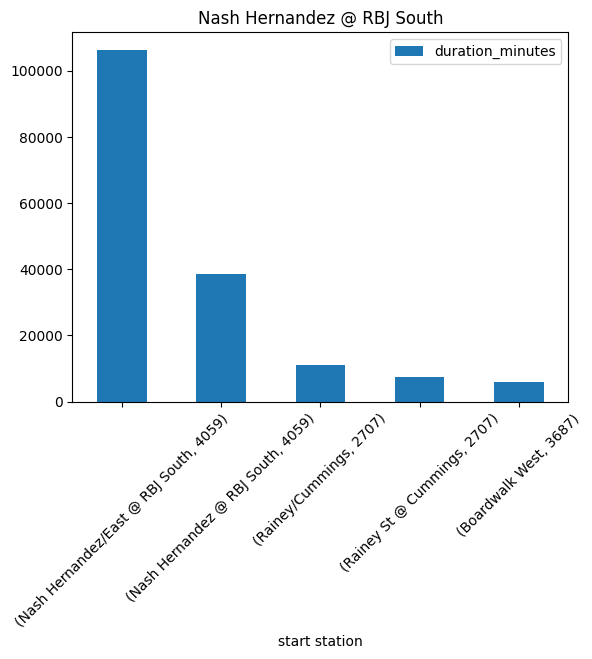

In [17]:
result_top5.plot(kind = 'bar', title =end_station_name,xlabel='start station', rot=45 )

In [19]:
url = 'http://127.0.0.1:5000/trips/total_duration_by_start_station/4059'
res = requests.get(url)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /trips/total_duration_by_start_station/4059 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002912D92E680>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [ ]:
res

In [ ]:
#top 5 sum of duration_minutes according to start stations
res.text

## Create POST Endpoints

You can use the following cell to try-out your function before implementing it as an endpoint.

If you still find it quite difficult, here's an example case you might wanted to try on:
- input : a dictionary contained a datetime period
    - { "period" : "2015-08" }
- output:
    - Aggregation table of bike rent activities for each station in that specific period
- example code: 

```python 
input_data = request.get_json() # Get the input as dictionary
specified_date = input_data['period'] # Select specific items (period) from the dictionary (the value will be "2015-08")

# Subset the data with query 
conn = make_connection()
query = f"SELECT * FROM stations WHERE start_time LIKE ({specified_date}%)"
selected_data = pd.read_sql_query(query, conn)

# Make the aggregate
result = selected_data.groupby('start_station_id').agg({
    'bikeid' : 'count', 
    'duration_minutes' : 'mean'
})

# Return the result
return result.to_json()

```

In [ ]:
#@app.route('/json_post_endpoint') 
#def json_post_endpoint():

#    input_data = request.get_json(force=True) # Get the input as dictionary
#specified_bike = input_data['18331'] # Select specific items (period) from the dictionary

specified_bike = '18331'

# Subset the data with query 
conn = make_connection()
query = f"SELECT * FROM trips WHERE bikeid= {specified_bike} "
selected_data = pd.read_sql_query(query, conn)

# Make the aggregate - frequency of rides and total duration for specified bike and period
result0 = selected_data.groupby(['start_station_name', 'end_station_name']).agg({'id' : 'count', \
'duration_minutes' : 'sum'})

#find sum of columns specified 
result = result0['duration_minutes'].sum(axis=0)
# Return the result
#    return result.to_json()

In [ ]:
result0

In [ ]:
# Get total of duration_minutes column using sum method
result0.loc['total'] = result0['duration_minutes'].sum()
print(result0)

In [ ]:
result

In [ ]:
data = { 
           "bikeid" : 18331
       }

url = "http://127.0.0.1:5000/json_post_endpoint"

In [ ]:
res = requests.post(url, json=data)

In [ ]:
res

In [ ]:
res_total_minutes_by_bikeid=pd.DataFrame(res.json())
res_total_minutes_by_bikeid.loc['total'] = res_total_minutes_by_bikeid['duration_minutes'].sum()
print(res_total_minutes_by_bikeid) #display total minutes of riding on bike_id


# Submission

After finishing your work of all the rubrics, the next step will be;

1. Prepare your `Bikeshare API.ipynb` file that has been edited with your code and wrangling data.
2. Prepare your `app.py` file for your Flask App. 
3. Submit your .ipynb and app.py file in your github repository. The dataset is optional to post since it has big size to post. 

